In [1]:
import numpy as np
import time
import os
import gendata
import torch
from torch.utils.data import TensorDataset
from scada.models.wdgrl import WDGRL
from scada.si_scada import run_scada, kmeans_withDA


c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ns, nt = 2000, 200
d = 10

Generate train data

In [3]:
mus = np.zeros((ns, d))
mut = np.full((nt, d), 2.0)
noise_s = np.random.normal(0, 1, (ns, d))
noise_t = np.random.normal(0, 1, (nt, d))
Xs = mus + noise_s
Xt = mut + noise_t

In [4]:
ns = Xs.shape[0]
nt = Xt.shape[0]

In [5]:
xs = torch.from_numpy(Xs).double()
xt = torch.from_numpy(Xt).double()

source_dataset = TensorDataset(xs)
target_dataset = TensorDataset(xt)

Train Representation Learning-based Domain Adaptation model

In [6]:
final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=[300,100],
    critic_hidden_dims=[100],
    alpha1=0.0001,
    alpha2=0.00001,
)

In [7]:

log_dir = "saved_models/ex2/"
os.makedirs(log_dir, exist_ok=True)

In [8]:
log_loss = final_model.train(
    source_dataset,
    target_dataset,
    num_epochs=3000,
    gamma=5.0,
    dc_iter=6,
    batch_size=32,
    early_stopping=True,
    model_path=log_dir,
)
final_model.save_model(log_dir)
total_loss = log_loss["loss"]


Epoch:   0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch:  54%|█████▎    | 1606/3000 [00:35<02:15, 10.30it/s]

Encoder and Critic saved to saved_models/ex2//early_model


Epoch:  57%|█████▋    | 1711/3000 [00:37<00:28, 45.35it/s]

Encoder and Critic saved to saved_models/ex2//early_model


Epoch:  70%|███████   | 2109/3000 [00:45<00:19, 45.15it/s]

Encoder and Critic saved to saved_models/ex2//early_model


Epoch:  74%|███████▎  | 2205/3000 [00:47<00:18, 43.20it/s]

Encoder and Critic saved to saved_models/ex2//early_model


Epoch:  77%|███████▋  | 2306/3000 [00:49<00:17, 40.58it/s]

Encoder and Critic saved to saved_models/ex2//early_model


Epoch: 100%|██████████| 3000/3000 [01:08<00:00, 43.88it/s]

Encoder and Critic saved to saved_models/ex2/


In [9]:
ns = 70
nt = 10
d = 10

In [10]:
from scada.utils.kmeans import kmeans

k-means clustering with k = 3 

In [11]:
device = "cpu"
K = 3

In [12]:
pvalue_list = []
for _ in range(120):
    # generate test data
    mus = np.zeros((ns, d))
    mut = np.full((nt, d), 2.0)
    noise_s = np.random.normal(0, 1, (ns, d))
    noise_t = np.random.normal(0, 1, (nt, d))
    Xs_test = mus + noise_s
    Xt_test = mut + noise_t

    Sigma = np.identity((ns + nt) * d)
    ns = Xs_test.shape[0]
    nt = Xt_test.shape[0]


    d = Xs_test.shape[1]
    n = ns + nt

    Xs_torch = torch.from_numpy(Xs_test).double().to(device)
    Xt_torch = torch.from_numpy(Xt_test).double().to(device)
    # print(Xt_torch.device)  
    with torch.no_grad():
        xs_hat = final_model.extract_feature(Xs_torch).cpu().numpy()
        xt_hat = final_model.extract_feature(Xt_torch).cpu().numpy()

    X_transformed = np.vstack((xs_hat, xt_hat))

    initial_centroids_obs, labels_all_obs, members_all_obs = kmeans(X_transformed, K)
    c1, c2 = np.random.choice(K, 2, replace=False)
    try:
        pvalue = run_scada(Xs = Xs_test, Xt=Xt_test, 
                        Sigma=Sigma, n_clusters=K, 
                        labels_all_obs= labels_all_obs, 
                        model_path=log_dir)
    except:
        continue
    pvalue_list.append(pvalue)

Encoder and Critic loaded from saved_models/ex2/


Progress: : 13868561it [00:25, 549462.24it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 12654662it [00:33, 375758.39it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9662435it [00:12, 751849.12it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 17907625it [00:12, 1419538.39it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10586304it [00:11, 901084.36it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10955394it [00:11, 975020.28it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13423258it [00:15, 865318.14it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9661167it [00:12, 783927.28it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8947370it [00:11, 779398.99it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 12660609it [00:12, 1036854.46it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 14160268it [00:14, 986368.10it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10583546it [00:11, 929036.57it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8948894it [00:13, 678474.23it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13664149it [00:13, 992192.40it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 13665191it [00:13, 1044505.49it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13858189it [00:15, 912385.71it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10005689it [00:11, 839849.82it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9240948it [00:12, 748146.87it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11550340it [00:10, 1063459.44it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10342735it [00:12, 843008.38it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11590042it [00:12, 930280.65it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 15494187it [00:12, 1205796.40it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 14147319it [00:15, 929113.64it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10337252it [00:13, 763127.00it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9670515it [00:09, 989836.16it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 15511045it [00:13, 1159890.44it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10338401it [00:12, 813354.07it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10337967it [00:12, 816395.57it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10167764it [00:13, 742603.43it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 14146795it [00:15, 914539.11it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8966035it [00:12, 743479.11it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10961788it [00:12, 906291.98it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10341699it [00:09, 1118465.18it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10346337it [00:14, 734882.98it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9664461it [00:10, 919964.77it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10626749it [00:12, 836767.01it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10340129it [00:12, 839916.86it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 8945432it [00:11, 784582.29it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10980096it [00:12, 861057.52it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13333537it [00:13, 1013608.16it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 8496397it [00:13, 648593.42it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11547430it [00:11, 1006735.75it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10957728it [00:12, 859987.86it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8000719it [00:13, 585274.21it/s]                           


Encoder and Critic loaded from saved_models/ex2/


Progress: : 14150982it [00:14, 990147.03it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8958262it [00:13, 645478.18it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13669510it [00:17, 778726.75it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 12656303it [00:13, 916591.95it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9248071it [00:12, 754396.31it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 13902215it [00:11, 1179323.45it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10962946it [00:13, 792857.74it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11548717it [00:13, 888330.64it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11558651it [00:11, 994762.94it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10590983it [00:13, 809058.49it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11548401it [00:11, 989684.05it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 15517698it [00:13, 1124973.37it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8944539it [00:11, 801634.47it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9283982it [00:11, 783309.74it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11547535it [00:13, 880080.42it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10600677it [00:12, 836672.39it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 13886116it [00:15, 868515.35it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13540778it [00:15, 882248.35it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9251398it [00:14, 659897.11it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10329071it [00:13, 768444.79it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13859806it [00:12, 1109623.50it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 8168239it [00:13, 590980.23it/s]                           


Encoder and Critic loaded from saved_models/ex2/


Progress: : 15497867it [00:11, 1366017.85it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13873026it [00:15, 924662.73it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9672693it [00:11, 827546.77it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 14642103it [00:15, 954087.68it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8182277it [00:13, 614370.92it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11567646it [00:10, 1110028.59it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 8176313it [00:16, 502282.83it/s]                           


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13422476it [00:13, 967788.12it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13857421it [00:14, 925551.65it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10002862it [00:12, 821605.72it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8500760it [00:11, 711227.14it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9668027it [00:09, 982509.89it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11557467it [00:12, 894364.16it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11549006it [00:10, 1134382.96it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 13667901it [00:11, 1158792.64it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 9255448it [00:10, 896464.02it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10328229it [00:12, 800797.48it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10147584it [00:12, 782971.95it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 9666863it [00:12, 789543.67it/s]                            


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 9663721it [00:11, 835865.30it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 10584510it [00:13, 773611.54it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11579942it [00:12, 910514.72it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 15497863it [00:15, 1022129.85it/s]                            


Encoder and Critic loaded from saved_models/ex2/


Progress: : 11547879it [00:13, 862895.52it/s]                             


Encoder and Critic loaded from saved_models/ex2/
Encoder and Critic loaded from saved_models/ex2/


Progress: : 10328438it [00:13, 791229.30it/s]                             


Encoder and Critic loaded from saved_models/ex2/


Progress: : 8488105it [00:13, 637411.25it/s]                           


Encoder and Critic loaded from saved_models/ex2/


Progress: : 13667014it [00:15, 907756.51it/s]                             


In [13]:
Alpha = 0.05

FPR: 0.06451612903225806
Uniform Check (KS test): 0.9167235148982689


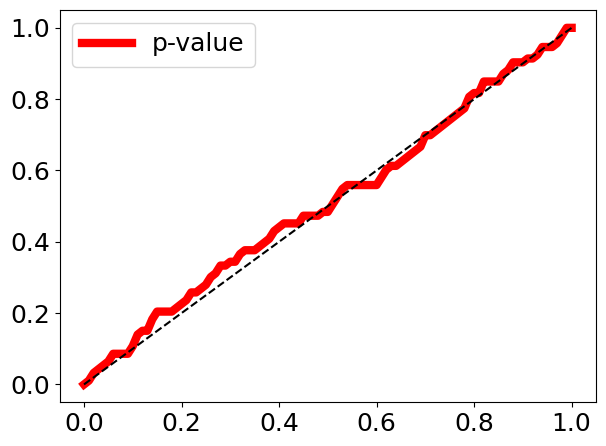

In [14]:
from scipy.stats import kstest
import matplotlib.pyplot as plt
import statsmodels.api as sm
detected = 0
rejected = 0

for p_value in pvalue_list:
    if p_value <= Alpha:
        detected += 1
    else:
        rejected += 1

FPR = detected / (detected + rejected) 
kstest = kstest(pvalue_list, 'uniform', args=(0, 1))

print(f"FPR: {FPR}")
print(f"Uniform Check (KS test): {kstest.pvalue}")
plt.rcParams.update({'font.size': 18})
grid = np.linspace(0, 1, 101)
plt.plot(grid, sm.distributions.ECDF(np.array(pvalue_list))(grid), 'r-', linewidth=6, label='p-value')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.tight_layout()
plt.show()